In [1]:
import numpy as np
np.set_printoptions(precision=2, suppress=True)
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

# Matrix Factorization

$X = PQ$となる分解を行う．  
Pのサイズは(# of users, k)，Qのサイズは(k, # of items)  
(kはハイパーパラメータ)

分解後にPとQの積をとるとXの欠損していた値が予測される．

In [2]:
X = np.array([
    [5, 3, 1, np.nan],
    [np.nan, np.nan, 4, 5], 
    [1, np.nan, 5, np.nan]])
reviewers = ['Alan', 'Benjamin', 'Carl']
movie_titles = ['Titanic', 'Notting Hill', 'Star Wars', 'Star Trek']

df = pd.DataFrame(X, index=reviewers, columns=movie_titles)
df = df.fillna(0)
X = df.values

df

,Titanic,Notting Hill,Star Wars,Star Trek
Alan,5.0,3.0,1.0,0.0
Benjamin,0.0,0.0,4.0,5.0
Carl,1.0,0.0,5.0,0.0


## 原理

MFではPQによるXの近似を損失最適化によって行う．

ユーザ$u_i$による項目$d_j$の評価$r_{ij}$は，
$$ r_{ij} = p_i^T q_j = \sum^k_{k=1} p_{ik} q_{kj} $$
UとVを求めるのに，元の行列と予測の損失$e_{ij}$を最小化していく．  
損失  
$$ e_{ij} = (r_{ij} - \sum^K_{k=1} p_{ik} q_{kj})^2$$
勾配
$$de_{ij}/dp_{ik} = -2e_{ij} q_{kj}$$
$$de_{ij}/dq_{ik} = -2e_{ij} p_{ik}$$
更新
$$p_{ik} = p_{ik} + \alpha \cdot 2 e_{ij} q_{kj} $$
$$q_{kj} = q_{kj} + \alpha \cdot 2 e_{ij} p_{ik} $$

ここで，PとQの積による欠損部分の予測は0になるのではないか，という疑問が出てくる．  
答えとしては，PとQは元の行列をそのまま再現しようとするのではなく，あくまで観測された部分の損失を最小化しようとするものであるため，欠損値を予測できる．

## 正則化
正則化は損失関数にハイパーパラメータ$\beta$を含む正則化項を加えることで行う．
正則化によって，PとQの値が大きくなるのを防ぐ．  
損失  
$$ e_{ij} = (r_{ij} - \sum^K_{k=1} p_{ik} q_{kj})^2 + \frac{\beta}{2} \sum^K_{k=1} (||P||^2 + ||Q||^2) $$
更新  
$$p_{ik} = p_{ik} + \alpha (2 e_{ij} q_{kj} - \beta p_{ik}) $$
$$q_{kj} = q_{kj} + \alpha (2 e_{ij} p_{ik} - \beta q_{kj})$$

In [3]:
class MatrixFactorization():
    def __init__(self, data, k_dim, step=1000, alpha=.002, beta=.02, threshold=.001):
        self.X = data
        self.k = k_dim
        self.P = np.random.rand(self.X.shape[0], self.k)
        self.Q = np.random.rand(self.k, self.X.shape[1])
        self.alpha = alpha
        self.beta = beta
        self.steps = step
        self.loss_history = []
    
    def fit(self):
        print('Started training')
        for step in range(self.steps):
            for i in range(self.X.shape[0]):
                for j in range(self.X.shape[1]):
                    if self.X[i][j] > 0:
                        error = self.X[i][j] - np.dot(self.P[i,:], self.Q[:,j])
                        for k in range(self.k):
                            self.P[i][k] = self.P[i][k] + self.alpha * (2 * error * self.Q[k][j] - self.beta * self.P[i][k])
                            self.Q[k][j] = self.Q[k][j] + self.alpha * (2 * error * self.P[i][k] - self.beta * self.Q[k][j])
            error = 0
            for i in range(self.X.shape[0]):
                for j in range(self.X.shape[1]):
                    if self.X[i][j] > 0:
                        error = error + pow(self.X[i][j] - np.dot(self.P[i,:], self.Q[:,j]), 2)
                        for k in range(self.k):
                            error = error + (self.beta/2) * (pow(self.P[i][k],2) + pow(self.Q[k][j],2))
            self.loss_history.append(error)
            if step % 50 == 0:
                 print('step {:4}: {:.2f}'.format(step, error), end='\r')
        print('Finished training')
        
    def predict_element(self, i, j):
        prediction = np.dot(self.P[i,:], self.Q[:,j])
        return prediction
    
    def predict(self):
        prediction = []
        for i, xi in enumerate(self.X):
            prediction.append([])
            for j, xij in enumerate(xi):
                prediction[i].append(self.predict_element(i,j))            
        return np.array(prediction)

Started training
Finished training
X
 [[5. 3. 1. 0.]
 [0. 0. 4. 5.]
 [1. 0. 5. 0.]]
Prediction
 [[4.98 2.99 1.   3.66]
 [3.79 2.61 3.99 4.99]
 [1.   1.02 4.98 3.  ]]
Loss: 0.68


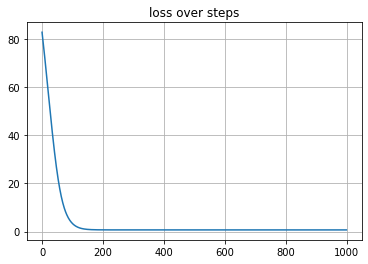

In [4]:
mf = MatrixFactorization(X, k_dim=3)
mf.fit()
prediction = mf.predict()

print('X\n',X)
print('Prediction\n',prediction)
print('Loss: {:.2f}'.format(mf.loss_history[-1]))
plt.title('loss over steps'); plt.grid(); plt.plot(mf.loss_history)
plt.show()

# バイアス項つきMatrix Factorization
ユーザまたはアイテム片方のみに依存する性質(辛口なユーザ，誰もに好かれる商品など)を反映したMatrix Factorization．  
予測規則  
$$ X = PQ + \mu + B^P + B^Q $$
更新  
$$ B^P_{ik} = B^P_{ik} + \alpha (e_{ij} - \beta * B^P_{ik}) $$
$$ B^Q_{kj} = B^Q_{kj} + \alpha (e_{ij} - \beta * B^Q_{kj}) $$

In [5]:
class BiasMF():
    def __init__(self, data, k_dim, step=1000, alpha=.002, beta=.02, threshold=.001):
        self.X = data
        self.k = k_dim
        self.P = np.random.rand(self.X.shape[0], self.k)
        self.Q = np.random.rand(self.k, self.X.shape[1])
        self.alpha = alpha
        self.beta = beta
        self.steps = step
        self.bias_p = np.zeros((self.X.shape[0], self.k))
        self.bias_q = np.zeros((self.k, self.X.shape[1]))
        self.bias = np.mean(data)
        self.loss_history = []
        
    def fit(self):
        print('Started training')
        for step in range(self.steps):
            for i in range(self.X.shape[0]):
                for j in range(self.X.shape[1]):
                    if self.X[i][j] > 0:
                        error = self.X[i][j] - self.predict_element(i, j)
                        for k in range(self.k):
                            self.bias_p[i][k] = self.bias_p[i][k] + self.alpha * (error - self.beta * self.bias_p[i][k])
                            self.bias_q[k][j] = self.bias_q[k][j] + self.alpha * (error - self.beta * self.bias_q[k][j])
                            self.P[i][k] = self.P[i][k] + self.alpha * (2 * error * self.Q[k][j] - self.beta * self.P[i][k])
                            self.Q[k][j] = self.Q[k][j] + self.alpha * (2 * error * self.P[i][k] - self.beta * self.Q[k][j])
            error = 0
            for i in range(self.X.shape[0]):
                for j in range(self.X.shape[1]):
                    if self.X[i][j] > 0:
                        error = error + pow(self.X[i][j] - self.predict_element(i,j), 2)
                        for k in range(self.k):
                            error = error + (self.beta/2) * (pow(self.P[i][k],2) + pow(self.Q[k][j],2))
            self.loss_history.append(error)
            if step % 50 == 0:
                 print('step {:4}: {:.2f}'.format(step, error), end='\r')
        print('Finished training')
    
    def predict_element(self, i, j):
        prediction = np.dot(self.P[i,:], self.Q[:,j])
        prediction += self.bias
        for k in range(self.bias_p.shape[1]):
            prediction += self.bias_p[i][k]
        for k in range(self.bias_q.shape[0]):
            prediction += self.bias_q[k][j]
        return prediction
    
    def predict(self):
        prediction = []
        for i, xi in enumerate(self.X):
            prediction.append([])
            for j, xij in enumerate(xi):
                prediction[i].append(self.predict_element(i,j))            
        return np.array(prediction)

Started training
Finished training
X
 [[5. 3. 1. 0.]
 [0. 0. 4. 5.]
 [1. 0. 5. 0.]]
Prediction
 [[4.98 2.99 1.01 3.09]
 [2.77 4.25 4.   4.99]
 [1.01 3.94 4.99 4.99]]
Loss: 0.34


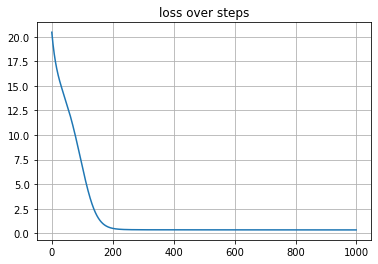

In [6]:
mf = BiasMF(X, k_dim=3)
mf.fit()
prediction = mf.predict()

print('X\n',X)
print('Prediction\n',prediction)
print('Loss: {:.2f}'.format(mf.loss_history[-1]))
plt.title('loss over steps'); plt.grid(); plt.plot(mf.loss_history)
plt.show()

## Non-negative Matrix Factorization

入力が非負という制約をつけたMatrix Factorization．  
[WIP] ブロードキャスト計算中にどうやって欠損値を判定するかが不明  
更新  
$$ P_{ik} = P_{ik}\frac{ [{\bf XQ}^T]_{ik}}{ [{\bf PQQ^T}]_{ik}} $$
$$ Q_{kj} = P_{kj}\frac{ [{\bf P}^T{\bf X}]_{kj}}{ [{\bf P}^T{\bf PQ}]_{kj}} $$

In [7]:
class NMF():
    def __init__(self, data, k_dim, step=1000, alpha=.002, beta=.02, threshold=.001):
        self.X = data
        self.k = k_dim
        self.P = np.random.rand(self.X.shape[0], self.k)
        self.Q = np.random.rand(self.k, self.X.shape[1])
        self.alpha = alpha
        self.beta = beta
        self.steps = step
        self.loss_history = []
        
    def fit(self):
        print('Started training')
        for step in range(self.steps):
            xqt = np.dot(self.X, self.Q.T)
            pqqt = np.dot(np.dot(self.P, self.Q), self.Q.T)
            self.P = self.P * xqt / pqqt
            ptx = np.dot(self.P.T, self.X)
            ptpq = np.dot(np.dot(self.P.T, self.P), self.Q)
            self.Q = self.Q * ptx / ptpq
            
            prediction = self.predict()
            error = np.sum(np.abs(self.X - prediction))
            self.loss_history.append(error)
            if step % 50 == 0:
                 print('step {:4}: {:.2f}'.format(step, error), end='\r')
        print('Finished training')
    
    def predict_element(self, i, j):
        prediction = np.dot(self.P[i,:], self.Q[:,j])
        return prediction
    
    def predict(self):
        prediction = []
        for i, xi in enumerate(self.X):
            prediction.append([])
            for j, xij in enumerate(xi):
                prediction[i].append(self.predict_element(i,j))            
        return np.array(prediction)

Started training
Finished training
X
 [[5. 3. 1. 0.]
 [0. 0. 4. 5.]
 [1. 0. 5. 0.]]
Prediction
 [[5.   3.   1.   0.  ]
 [0.02 0.   4.   5.  ]
 [1.   0.   5.   0.  ]]
Loss: 0.03


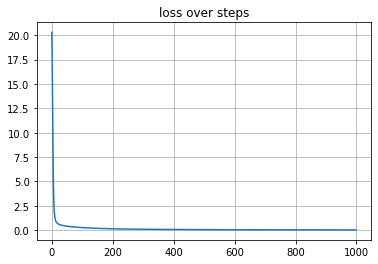

In [8]:
mf = NMF(X, k_dim=3)
mf.fit()
prediction = mf.predict()

print('X\n',X)
print('Prediction\n',prediction)
print('Loss: {:.2f}'.format(mf.loss_history[-1]))
plt.title('loss over steps'); plt.grid(); plt.plot(mf.loss_history)
plt.show()